# Put Credit Spread (Bull Put Spread)

### I. Strategy Overview

* This strategy is composed of 2 put options:
    * Short Leg: OTM put option typically set around 20-30 delta with <30% ITM by expiration
    * Long Leg: Further OTM put option to (1) cap the maximum loss, and (2) reduce buying power requirement
* Compared to short put option, this trategy releases lots of buying powera by defining risk

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

![](put_credit_spread.jpg)

#### Features （Optional):
* Defined risk strategy (known max profit and loss)
* Long Delta: profit of the strategy increases as the underlying price goes up
* Long Theta: profit of the strategy increases as time decays
* Short volatility: profit of the strategy increases as the implied volatility drops

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [5]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta
from IPython.display import display, HTML

####  a. Select underlying by ticker

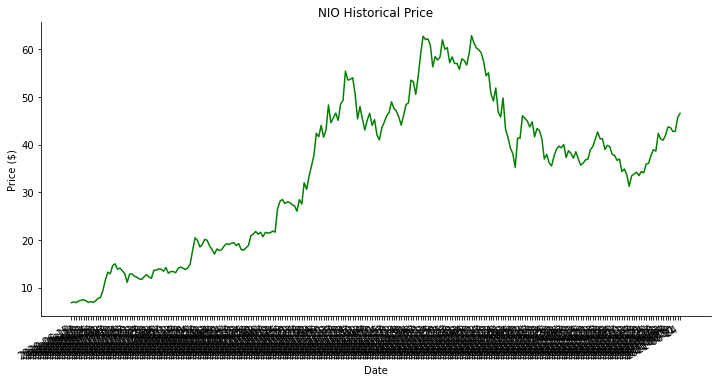

In [2]:
Ticker = 'NIO'
GetPriceHistory(Ticker).plot_price_history()

#### b1. Find expiration dates for testing period

In [3]:
GetPriceHistory(Ticker).expiration_dates

0     2021-06-18
1     2021-06-25
2     2021-07-02
3     2021-07-09
4     2021-07-16
5     2021-07-23
6     2021-07-30
7     2021-08-20
8     2021-09-17
9     2021-10-15
10    2021-11-19
11    2021-12-17
12    2022-01-21
13    2022-02-18
14    2022-03-18
15    2022-06-17
16    2022-09-16
17    2022-12-16
18    2023-01-20
Name: Date, dtype: object

#### b2. Find expiration dates for testing period

In [14]:
strikes = GetPriceHistory(Ticker).strikes
display(HTML(strikes[strikes.index=="2021-07-16"].to_html()))

,strikes
Date,
2021-07-16,"[17.5, 20.0, 22.5, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0]"


#### c. Select an expiration date, choose option type (call) and strike price

In [15]:
expiration = datetime.datetime(2021, 7, 30)
option_type = ['P', 'P']  # C(all), P(ut)
action = ['L', 'S']  #L(ong), S(hort)

strike_price = [35, 40]

#### d. Choose option enter and exit dates

In [19]:
entry_date = datetime.datetime(2021, 5, 27)
exit_date = datetime.date.today()

### III. Visualization
#### a. Generate option(s) price and payoff

In [20]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[1] - payoff.option_price[0]))
payoff.plot_payoff()

TypeError: unsupported operand type(s) for -: 'datetime.date' and 'datetime.datetime'

#### * Probability of profit here is incorrect (should be higher than short put strategy, needs more work)

##### b. Compare returns by holding the option vs. buy&hold the underlying

In [ ]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

In [ ]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [ ]:
bt1.strategy_summary

### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [ ]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices:
* Long leg: enter day underlying price - \\$8
* Short leg: enter day underlying price - \\$5

In [ ]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [ ]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [32, 35]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-8, end_of_period_spot-5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [ ]:
win_rate

In [ ]:
strategy_performance.reset_index(drop=True, inplace=True)
strategy_performance

In [ ]:
strategy_performance['Cost Basis']
print('Average Cost: ', "${:.2f}".format(500)) 

#### *Note that for defined risk strategies, cost = buying power effect = 100 x width between two strike prices

In [ ]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))